Loaded pretrained weights for efficientnet-b0


/tmp/ipykernel_15217/3434676891.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/mnt/c/Users/Rahul/Desktop/Document-and-Record-Managem

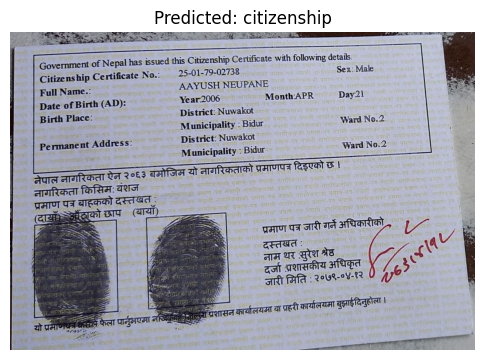

The predicted class for the image is: citizenship


In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from efficientnet_pytorch import EfficientNet

# Define the DocumentClassifier class
class DocumentClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(DocumentClassifier, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        num_features = self.backbone._fc.in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.6),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DocumentClassifier(num_classes=3)
model.load_state_dict(torch.load('/mnt/c/Users/Rahul/Desktop/Document-and-Record-Management/pretrained models/document_classifier.pth'))
model.to(device)
model.eval()

# Class mapping
class_mapping = {0: 'citizenship', 1: 'license', 2: 'passport'}

# Preprocessing steps (same as during training)
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Inference function
def infer(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_batch)
        _, predicted_class = torch.max(output, 1)
    
    predicted_class = predicted_class.item()
    predicted_label = class_mapping[predicted_class]
    
    plt.figure(figsize=(6, 6))
    img_np = np.array(image)
    plt.imshow(img_np)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()
    
    return predicted_label

# Example usage
image_path = 'aayush back.jpg'
predicted_class = infer(image_path)
print(f'The predicted class for the image is: {predicted_class}')
